<a href="https://colab.research.google.com/github/msasen/pytorch/blob/main/1-transform-islemleri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1-transform-islemleri.ipynb
from google.colab import files
uploaded = files.upload()

matplotlib ile birden çok resmi aynı anda gösterme

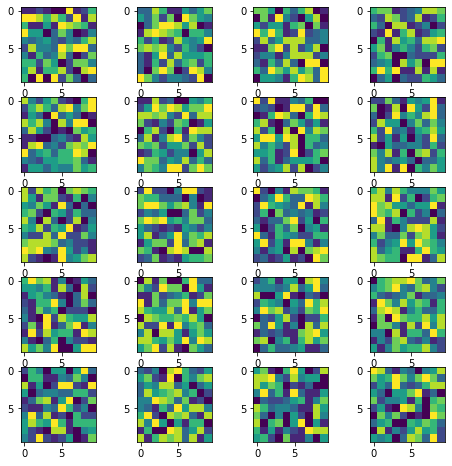

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

Aşağıda pytorch'da transform işlemlerinin kullanıldığı örnek bir kod verilmiştir. Biz bu rehberde bunu örneği adım adım inceleyeceğiz. 

In [ ]:
#!pip install torch torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import torchvision.transforms as T
from torch.nn.functional import normalize
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


# Transforms'ları anlamak 
## 1) Resize
  Resize() dönüşümü girdi görüntüsünü belirli bir boyuta yeniden boyutlandırır. Torchvision.transforms modülü tarafından sağlanan dönüşümlerden biridir. Resize() hem PIL hem de tensör görüntülerini kabul eder. Bir tensör görüntüsü [C, H, W] şeklinde bir torch tensörüdür; burada C kanal sayısı, H görüntü yüksekliği ve W görüntü genişliğidir.

Bu dönüşüm aynı zamanda [B, C, H, W] şeklinde bir tensör olan bir tensör görüntü grubunu da kabul eder; burada B, gruptaki görüntü sayısıdır. Bir görüntü PIL yada tensör görüntüsü değilse, önce onu tensör görüntüsüne dönüştürürüz ve ardından Resize()dönüşümünü uygularız.

In [ ]:
img = Image.open('/content/resim.png')
print(type(img))
# Açıklama aşağıda
print(img.mode) 
print(img)
if img.mode == 'CMYK' or img.mode == 'RGBA':
    img = img.convert('RGB')
print(img.mode)


<class 'PIL.PngImagePlugin.PngImageFile'>
RGBA
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=360x442 at 0x7F76B2C6CFD0>
RGB


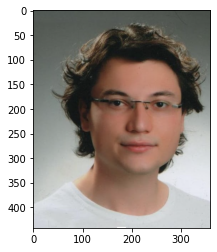

In [ ]:
transform = T.Resize((32,32))

resized_img = transform(img)
plt.imshow(resized_img)
plt.imshow(img)

## 2)ToTensor()


ToTensor'un kullanımı son derece kolaydır. 

In [ ]:
transform = T.ToTensor()
tensor = transform(resized_img)
print(tensor.shape)
# ----------------
transform = T.ToTensor()
tensor = transform(img)
print(tensor.shape)

torch.Size([3, 32, 32])
torch.Size([3, 442, 360])


Burada T.resize fonksiyonumuzun resmin şekli üzerindeki etkisi açık bir şekilde görülmekteidr.
torch.Size([4, 32, 32])
torch.Size([4, 442, 360])
Buradaki matris'i yukarıdada bahsettiğimiz gibi  [C, H, W] şeklinde anlamlandırabiliriz. Buradaki Birinci kısım kanal 2. kısım Yükseklik 3. kısım genişliktir. 


* **Peki kanal neden 4**
Muhtemelen H ve W değerlerinin neden 32 olduğunu anladınız. Peki kanal değeri neden 4?

  * Bu tamamen Renk modeli ile alakalıdır. 
Bizim birkaç farklı renk modelimiz var. Bunlardan en çok kullanılanlar RGB, RGBA, CMYK dır.  
RGBA ve RGB arasındaki fark A(Alfa) kanalı ile resimleri ve pikselleri transparan yapabilmemizdir. Bu A kanalı bizim matris boyutumuzudu [3,h,w] den
 [4,h,w] ye çıkarmıştır.
![img](https://i.stack.imgur.com/nnQrb.png)
![img](https://i.stack.imgur.com/YCJsx.png)
Görüldüğü gibi daha çok çıktı almak için kullanılan CMYK görüntünün 4 kanalı varken RGB görüntünün 3 kanalı vardır. Bu durumda Renk modelimiz CMYK olması bize dijital ortamda ekstra maliyet oluşturmaktadır. Aynı RGBA resimlerin A kanalıda ekstrem bir durum olmadıkça bizim için benzer bir maliyet oluşturmaktadır.
    image = image.convert('RGB')
Bu durumlarda resmimlerimizi 'RGB' ye çevirirerek normalize edebiliriz.

In [ ]:
transform = T.ToTensor()
print(resized_img.mode)
resized_img_tensor = transform(resized_img)
print(tensor.shape)
img_tensor = transform(img)
print(tensor.shape)

RGB
torch.Size([3, 442, 360])
torch.Size([3, 442, 360])


## Normalize
Görüntü dönüşümü, görüntü piksellerinin orijinal değerlerini bir dizi yeni değerle değiştirme işlemidir. Görüntüler üzerinde yaptığımız bir dönüşüm türü, bir görüntüyü PyTorch tensörüne dönüştürmektir. Bir görüntü PyTorch tensörüne dönüştürüldüğünde, piksel değerleri 0,0 ile 1,0 arasında ölçeklendirilir. PyTorch'ta bu dönüşüm torchvision.transforms.ToTensor() kullanılarak yapılabilir. 0, 255] piksel aralığına sahip PIL görüntüsünü [0.0, 1.0] aralığına sahip (C, H, W) şeklinde bir PyTorch FloatTensörüne dönüştürür. 

Görüntülerin normalleştirilmesi, derin sinir ağları ile çalışırken çok iyi bir uygulamadır. Görüntüleri normalleştirmek, görüntüleri öyle değerlere dönüştürmek anlamına gelir ki görüntünün ortalaması ve standart sapması sırasıyla 0,0 ve 1,0 olur. Bunu yapmak için önce her bir giriş kanalından kanal ortalaması çıkarılır ve ardından sonuç kanal standart sapmasına bölünür. 


```
output[channel] = (input[channel] - mean[channel]) / std[channel]
```
### Görüntüleri neden normalleştirmeliyiz
Normalleştirme, verileri bir aralık içinde tutmaya yardımcı olur ve çarpıklığı azaltarak daha hızlı ve daha iyi öğrenmeye yardımcı olur. Normalleştirme ayrıca azalan ve patlayan gradyan sorunlarının da üstesinden gelebilir.

### PyTorch'ta Görüntüleri Normalleştirme
PyTorch'ta normalleştirme torchvision.transforms.Normalize() kullanılarak yapılır. Bu, tensör görüntüsünü ortalama ve standart sapma ile normalleştirir. 
* mean: Sequence of means for each channel.
* std: Sequence of standard deviations for each channel.
* inplace: Bool to make this operation in-place.
* Returns: Normalized Tensor image.



### Öncelikle bir resmin normalize edilmeden önceki halini matplotlib ile görselleştirelim. 
Görselleştirmek istediğimiz resmin şeklini yukarıdan [3,442,360] olarak öğrendik. Bu [c,w,h]'dan oluşan 3 boyutlu bir matris. Bu matrisin piksel dağılımını görselleştirebilmek için tek boyuta indirgememiz gerekir. bunun için bir numpy fonksiyonu olan ravel kullanabiliriz.


In [ ]:
print("önceki matris"+str(img_np.shape))
print("olması gereken tek boyutlu matris(3*442*360) : " + str(3*442*360))
print("ravel fonksiyonunun oluşturduğu matris " + str(img_np.ravel().shape) )

önceki matris(3, 442, 360)
olması gereken tek boyutlu matris(3*442*360) : 477360
ravel fonksiyonunun oluşturduğu matris (477360,)


Buradan açık ve net görüldüğü gibi basit bir matris manüpilasyonu ile 3 boyutlu bir matris tek boyuta indirgenmiştir. Şimdi sırada bu tek boyuta indirgediğimiz matrisin piksel dağılımını görelim:

Text(0.5, 1.0, 'distribution of pixels')

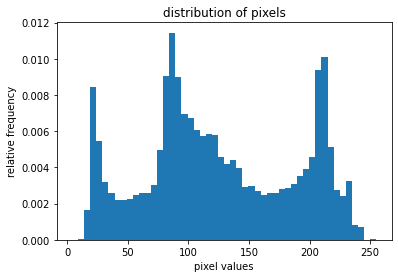

In [ ]:
img_np = np.array(img)
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")


Burada görüldüğü gibi 0-255 aralığında bir pixel dağılımımız var. Peki şimdi tensor için bakalım. 

Text(0.5, 1.0, 'distribution of pixels')

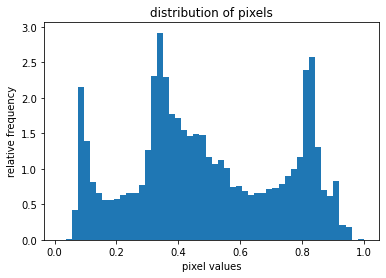

In [ ]:
img_np = np.array(img_tensor) 
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")


Bu sefer tensör görüntüsünün piksel değerlerinin 0.0 ile 1.0 arasında olduğunu bulduk. RBG ve tensör görüntüsünün piksel dağılımlarının aynı göründüğünü ancak piksel değerleri aralığında farklılık gösterdiğini fark ettik.

Text(0.5, 1.0, 'distribution of pixels')

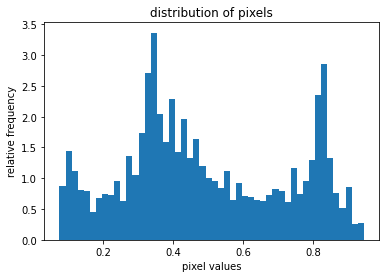

In [ ]:
img_np = np.array(resized_img_tensor) 
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [ ]:
mean, std = resized_img_tensor.mean([1,2]), resized_img_tensor.std([1,2])
 
# print mean and std
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.5322, 0.4858, 0.4534])
Std of the image: tensor([0.2253, 0.2274, 0.2430])


In [ ]:
mean, std = img_tensor.mean([1,2]), img_tensor.std([1,2])
print(mean,std)
normalize_func = T.Normalize(mean, std)
img_normalized = normalize_func(img_tensor)

tensor([0.5322, 0.4858, 0.4534]) tensor([0.2352, 0.2355, 0.2504])


Text(0.5, 1.0, 'distribution of pixels')

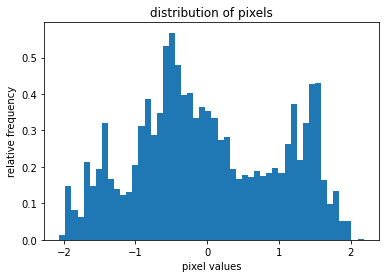

In [ ]:

img_np = np.array(img_normalized)
 
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

([], <a list of 0 Text major ticklabel objects>)

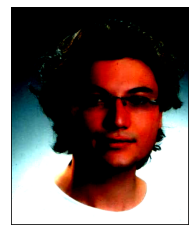

In [ ]:
img_normalized = np.array(img_normalized)
img_normalized = img_normalized.transpose(1, 2, 0)
 
# display the normalized image
plt.imshow(img_normalized)
plt.xticks([])
plt.yticks([])

Eğer veriniz ImageNet dataset'inin verilerine benziyorsa yani bir röntgen yada mr verileri değilse bu verisetinin ortalamasını kullanmakta sizin için faydalı olabilir.

([], <a list of 0 Text major ticklabel objects>)

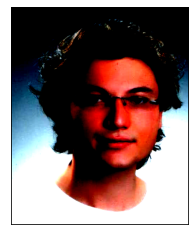

In [ ]:
normalize_func = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
img_normalized = normalize_func(img_tensor)
img_normalized = np.array(img_normalized)
img_normalized = img_normalized.transpose(1, 2, 0)
plt.imshow(img_normalized)
plt.xticks([])
plt.yticks([])

T.compose birden çok transformu bir arada kullanılmasını sağlar aşağıda bununla ilgili bir örnek bulunmakta.

In [ ]:
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## CenterCrop kullanımı



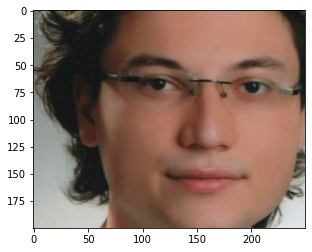

In [ ]:
transform = T.CenterCrop((200,250))
center_crop_img = transform(img)
plt.imshow(center_crop_img)


## ColorJitter kullanımı



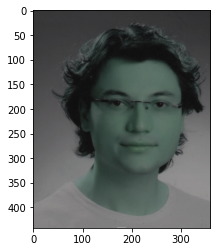

In [ ]:
transform = T.ColorJitter(brightness=1, contrast=1, saturation=1,hue= 0.5)
Color_jitter_img = transform(img)
plt.imshow(Color_jitter_img)


## FiveCrop kullanımı
**önemli not: resimlerin orta kısmını kaybetmemesi için ölçerek ekleme yapılmalıdır**


5


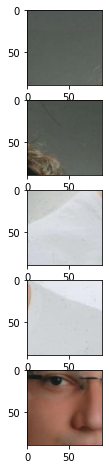

In [ ]:
transform = T.FiveCrop(90)
FiveCrop_imgs = transform(img)
print(len(FiveCrop_imgs))
fig = plt.figure(figsize=(8, 8))
columns = 1
rows = len(FiveCrop_imgs)
for i in range(1, columns*rows +1):
    img = FiveCrop_imgs[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Sinir ağını tanımlayın
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Verileri yükleyin ve normalize edin
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Sinir ağını oluşturun ve eğitin
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
